In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


/Users/yogithapalukuri/Desktop/capstone_project/myvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv('df_clean_v2.csv')

In [4]:
df

,tank100_temperature,tank200_temperature,tank300_temperature,tank400_temperature,tank100_pressure,tank200_pressure,tank300_pressure,tank400_pressure,tank100_station3_program_run,tank200_station3_program_run,...,tank400_station4_flow_rate,tank100_station5_quantity_selected,tank100_station5_flow_rate,tank200_station5_quantity_selected,tank200_station5_flow_rate,tank300_station5_quantity_selected,tank300_station5_flow_rate,tank400_station5_quantity_selected,tank400_station5_flow_rate,Timestamp
0,71.304199,28.074915,70.740761,71.908691,1.729645,1.669113,-0.056244,1.418671,0,0,...,-0.046997,1667.0,-0.044327,0.0,-0.051575,1048.0,-0.078964,1119.0,-0.042496,2024-04-30 15:43:02
1,71.303558,28.075108,70.739029,71.910446,2.108749,1.668274,-0.047394,1.419708,0,0,...,-0.052567,1667.0,-0.043335,0.0,-0.054626,1048.0,-0.067368,1119.0,-0.038300,2024-04-30 15:43:04
2,71.303177,28.074392,70.742981,71.910446,2.410660,4.193314,-0.028687,1.302017,0,0,...,-0.049667,1667.0,-0.040283,0.0,-0.051117,1048.0,-0.071335,1119.0,-0.041733,2024-04-30 15:43:05
3,71.325233,28.073294,70.741859,71.909592,10.575425,19.880661,12.796706,29.323227,0,1,...,-0.053864,1667.0,-0.053558,0.0,-0.053711,1048.0,-0.078506,1119.0,-0.041885,2024-04-30 15:43:08
4,71.297272,28.070629,70.741440,71.914780,11.344177,19.783142,12.850983,38.110352,0,1,...,-0.051422,1667.0,-0.050812,0.0,-0.052948,1048.0,-0.080795,1119.0,-0.045090,2024-04-30 15:43:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,71.047958,28.076069,70.431908,71.799896,10.638169,19.616257,12.991164,36.208649,0,0,...,-0.051575,1269.0,-0.048828,1791.0,-0.051117,847.0,-0.067291,264.0,-0.032272,2024-04-30 16:24:31
2045,71.052223,28.079666,70.461319,71.796524,10.580735,19.557449,13.017029,36.186890,0,0,...,-0.049362,1269.0,-0.051651,1791.0,-0.052643,847.0,-0.074005,264.0,-0.035095,2024-04-30 16:24:32
2046,71.052032,28.051762,70.473740,71.791824,10.165573,19.650101,12.880280,36.147400,0,0,...,-0.050201,1269.0,-0.049973,1791.0,-0.053940,847.0,-0.079803,264.0,-0.044785,2024-04-30 16:24:33
2047,71.047913,28.075710,70.489120,71.776657,10.344468,19.041092,12.919037,36.101608,0,0,...,-0.052567,1269.0,-0.048141,1791.0,0.389175,847.0,-0.081711,264.0,-0.035095,2024-04-30 16:24:34


In [5]:
anomaly_columns = ['tank100_temperature', 'tank200_temperature', 'tank300_temperature',
       'tank400_temperature', 'tank100_pressure', 'tank200_pressure',
       'tank300_pressure', 'tank400_pressure', 'all_tanks_station3_flow_rate', 
       'tank100_station4_flow_rate', 'tank200_station4_flow_rate', 'tank300_station4_flow_rate',
       'tank400_station4_flow_rate','tank100_station5_flow_rate','tank200_station5_flow_rate',
        'tank300_station5_flow_rate',
       'tank400_station5_flow_rate',
       ]

In [6]:
df.columns

Index(['tank100_temperature', 'tank200_temperature', 'tank300_temperature',
       'tank400_temperature', 'tank100_pressure', 'tank200_pressure',
       'tank300_pressure', 'tank400_pressure', 'tank100_station3_program_run',
       'tank200_station3_program_run', 'tank300_station3_program_run',
       'tank400_station3_program_run', 'tank100_station4_program_run',
       'tank200_station4_program_run', 'tank300_station4_program_run',
       'tank400_station4_program_run', 'tank100_station5_program_run',
       'tank200_station5_program_run', 'tank300_station5_program_run',
       'tank400_station5_program_run', 'tank100_station3_valve_run',
       'tank200_station3_valve_run', 'tank300_station3_valve_run',
       'all_tanks_station3_flow_rate', 'all_tanks_station3_quantity_selected',
       'tank100_station4_flow_rate', 'tank100_station4_quantity_selected',
       'tank200_station4_flow_rate', 'tank200_station4_quantity_selected',
       'tank300_station4_quantity_selected', 'tank300_s

In [149]:
def mean_absolute_percentage_error(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100



In [207]:
def get_prophet_predictions(df, columns_name):
    # Resample data to have a frequency of 1 second
    # df = df.set_index('Timestamp').resample('1S').ffill()
    # df = df.set_index('Timestamp')
    df.reset_index(drop = True, inplace = True)
    df.columns = ['ds', 'y']

    # Initialize and train Prophet model
    model = Prophet(growth= 'linear', 
                    interval_width = 0.01, 
                    changepoint_range = 0.01, 
                    changepoint_prior_scale=0.001)
    model.fit(df)

    # Increase uncertainty_samples
    # model.stan_backend.stan_fit_kwargs['iter'] = 100


    # Create a DataFrame with timestamps for the next 5 minutes with a frequency of 1 second
    start_time = df['ds'].iloc[-1] + timedelta(seconds=1)
    end_time = start_time + timedelta(minutes=30)

    print("start_time:", start_time, type(start_time))
    print("end_time:", end_time, type(end_time))

    # Create a dataframe containing the dates you want to forecast
    future = pd.DataFrame({
        'ds': pd.date_range(start=start_time, end=end_time, freq='S')
    })

    # print("future", future.shape, future.head(), future.tail())

    # Make predictions for the next 5 minutes
    forecast = model.predict(future)

    train_predicted = list(model.predict(df[['ds']])['yhat'])
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(list(df['y']), train_predicted)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(list(df['y']), train_predicted)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate R-squared (R2) score
    r2 = r2_score(list(df['y']), train_predicted)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(list(df['y']), train_predicted)
    print("Mean Absolute Percentage Error (MAPE):", mape)



    # Extract predicted values for the next 5 minutes
    predicted_values = forecast[['ds', 'yhat']].tail(1800)
    predicted_values.reset_index(drop = True, inplace = True)
    predicted_values.columns = ['Timestamp', columns_name]
    # print("predicted_values", predicted_values.shape, predicted_values.head(), predicted_values.tail())
    predicted_values.to_csv('predicted_values_'+columns_name+'.csv')
    return predicted_values, mae, mse, rmse, r2, mape

In [ ]:
output_df_with_prophet = pd.DataFrame()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
accuracy_df = pd.DataFrame()
# Perform anomaly detection for each column
for i, column in enumerate(anomaly_columns):
    # Fit Isolation Forest model
    model = IsolationForest(contamination=0.001)  # Adjust contamination based on expected outlier ratio
    model.fit(df[[column]])

    # Based on current data forcast for next 5 min of data with frequency 1 sec
    predicted_values,mae, mse, rmse, r2, mape = get_prophet_predictions(df[['Timestamp', column]].copy(), column)
 
    # accuracy_df
    accuracy_df.loc[i, 'column'] = column
    accuracy_df.loc[i, 'mae'] = mae
    accuracy_df.loc[i, 'mse'] = mse
    accuracy_df.loc[i, 'rmse'] = rmse
    accuracy_df.loc[i, 'r2'] = r2
    accuracy_df.loc[i, 'mape'] = mape

    # Predict anomalies
    anomalies = model.predict(df[[column]])
    df[column+'_is_anomaly'] = anomalies
    df[column+'_is_anomaly'] = df[column+'_is_anomaly'].replace([1,-1], [0,1])


    # Predict anomalies
    anomalies = model.predict(predicted_values[[column]])
    output_df_with_prophet['Timestamp'] = predicted_values['Timestamp']
    output_df_with_prophet[column] = predicted_values[column]
    output_df_with_prophet[column+'_is_anomaly'] = anomalies
    output_df_with_prophet[column+'_is_anomaly'] = output_df_with_prophet[column+'_is_anomaly'].replace([1,-1], [0,1])
    print("column", column, output_df_with_prophet[column+'_is_anomaly'].sum())



In [209]:
output_df_with_prophet

,Timestamp,tank100_temperature,tank100_temperature_is_anomaly,tank200_temperature,tank200_temperature_is_anomaly,tank300_temperature,tank300_temperature_is_anomaly,tank400_temperature,tank400_temperature_is_anomaly,tank100_pressure,...,tank400_station4_flow_rate,tank400_station4_flow_rate_is_anomaly,tank100_station5_flow_rate,tank100_station5_flow_rate_is_anomaly,tank200_station5_flow_rate,tank200_station5_flow_rate_is_anomaly,tank300_station5_flow_rate,tank300_station5_flow_rate_is_anomaly,tank400_station5_flow_rate,tank400_station5_flow_rate_is_anomaly
0,2024-04-30 16:24:38,71.021445,0,28.075339,0,70.439107,0,71.751281,0,10.487274,...,-0.023586,0,-0.017462,0,-0.002095,0,-0.041040,0,-0.017293,0
1,2024-04-30 16:24:39,71.021470,0,28.075339,0,70.439027,0,71.751260,0,10.487266,...,-0.023583,0,-0.017476,0,-0.002091,0,-0.041037,0,-0.017296,0
2,2024-04-30 16:24:40,71.021494,0,28.075339,0,70.438947,0,71.751239,0,10.487258,...,-0.023580,0,-0.017489,0,-0.002087,0,-0.041035,0,-0.017299,0
3,2024-04-30 16:24:41,71.021519,0,28.075339,0,70.438867,0,71.751217,0,10.487250,...,-0.023577,0,-0.017503,0,-0.002083,0,-0.041032,0,-0.017302,0
4,2024-04-30 16:24:42,71.021544,0,28.075339,0,70.438787,0,71.751196,0,10.487242,...,-0.023574,0,-0.017516,0,-0.002080,0,-0.041029,0,-0.017305,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2024-04-30 16:54:33,71.065900,0,28.075257,0,70.295606,0,71.713505,0,10.473066,...,-0.018332,0,-0.041690,0,0.004842,0,-0.036254,0,-0.022951,0
1796,2024-04-30 16:54:34,71.065925,0,28.075257,0,70.295527,0,71.713484,0,10.473058,...,-0.018330,0,-0.041704,0,0.004846,0,-0.036252,0,-0.022954,0
1797,2024-04-30 16:54:35,71.065950,0,28.075257,0,70.295447,0,71.713463,0,10.473050,...,-0.018327,0,-0.041717,0,0.004850,0,-0.036249,0,-0.022957,0
1798,2024-04-30 16:54:36,71.065974,0,28.075256,0,70.295367,0,71.713442,0,10.473042,...,-0.018324,0,-0.041731,0,0.004854,0,-0.036246,0,-0.022960,0


In [210]:
accuracy_df

,column,mae,mse,rmse,r2,mape
0,tank100_temperature,0.017014,0.001134,0.033675,0.222724,0.023956
1,tank200_temperature,0.005437,0.000436,0.020878,0.000003,0.019360
2,tank300_temperature,0.024422,0.001558,0.039473,0.681201,0.034603
3,tank400_temperature,0.024630,0.001962,0.044293,0.104971,0.034289
4,tank100_pressure,0.372553,0.331607,0.575853,-0.000310,4.033258
5,tank200_pressure,0.096312,0.447316,0.668817,0.001535,1.597187
6,tank300_pressure,0.354940,0.543873,0.737478,0.004177,49.037220
7,tank400_pressure,0.268695,2.200940,1.483557,0.000986,4.342519
8,all_tanks_station3_flow_rate,0.365305,1.520394,1.233043,-0.000125,487.571752
9,tank100_station4_flow_rate,0.000000,0.000000,0.000000,1.000000,0.000000


In [211]:
output_df_with_prophet['tank400_temperature_is_anomaly'].value_counts()

tank400_temperature_is_anomaly
0    1800
Name: count, dtype: int64

In [212]:
final_df = pd.concat([df,output_df_with_prophet], ignore_index= True)

In [213]:
output_df = final_df.copy()
output_df['Timestamp'] = pd.to_datetime(output_df['Timestamp'])

In [214]:
def plot_combined_time_series_overlap(df, column_list, variable_type):
    plt.figure(figsize=(10, 10))  # Adjust figure size as needed
    
    # Iterate over each column in the list
    for col in column_list:
        # Plot the time series data
        plt.plot(df['Timestamp'], df[col], label=col)
        
        # Highlight anomaly values in red
        anomaly_indices = df[df[col+'_is_anomaly'] == 1].index
        anomaly_values = df.loc[anomaly_indices, col]
        plt.scatter(df.loc[anomaly_indices, 'Timestamp'], anomaly_values, color='red', label=f'Anomaly in {col}')

    # Add labels and title
    plt.xlabel('Timestamp')
    plt.ylabel(variable_type)
    plt.title('Combined Time Series with Anomalies')
    plt.legend()

    # Show plot
    plt.show()

In [215]:
def plot_combined_time_series_stack(df, column_list, variable_type):
    plt.figure(figsize=(10, len(column_list)*3))  # Adjust figure size as needed
    
    # Calculate the number of subplots
    num_plots = len(column_list)
    
    # Iterate over each column in the list
    for i, col in enumerate(column_list):
        # Create a subplot for each column
        ax = plt.subplot(num_plots, 1, i+1)
        
        # Plot the time series data
        ax.plot(df['Timestamp'], df[col], label=col)
        
        # Highlight anomaly values in red
        anomaly_indices = df[df[col+'_is_anomaly'] == 1].index
        anomaly_values = df.loc[anomaly_indices, col]
        ax.scatter(df.loc[anomaly_indices, 'Timestamp'], anomaly_values, color='red', label=f'Anomaly in {col}')

        # Add labels and title
        ax.set_ylabel(variable_type)
        ax.set_title(f'{col} Time Series with Anomalies')
        
    # Add common x-axis label
    plt.xlabel('Timestamp')
    
    # Show legend
    # plt.legend()
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show plot
    plt.show()


In [216]:
temprature_list = ['tank100_temperature',
                    'tank200_temperature',
                    'tank300_temperature',
                    'tank400_temperature']

pressure_list = ['tank100_pressure',
                'tank200_pressure',
                'tank300_pressure',
                'tank400_pressure']

flow_rate_list = ['all_tanks_station3_flow_rate',
                    'tank100_station4_flow_rate',
                    'tank200_station4_flow_rate',
                    'tank300_station4_flow_rate',
                    'tank400_station4_flow_rate',
                    'tank100_station5_flow_rate',
                    'tank200_station5_flow_rate',
                    'tank300_station5_flow_rate',
                    'tank400_station5_flow_rate']

## Actual values


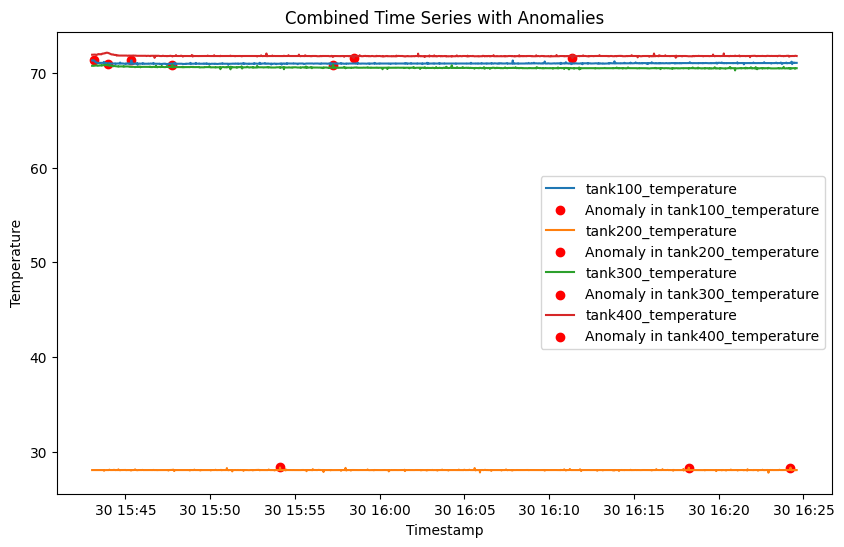

In [228]:
# Assuming output_df is your DataFrame and anomaly_columns is your list of columns
# plot_combined_time_series_overlap(df.copy(), temprature_list, 'Temperature')

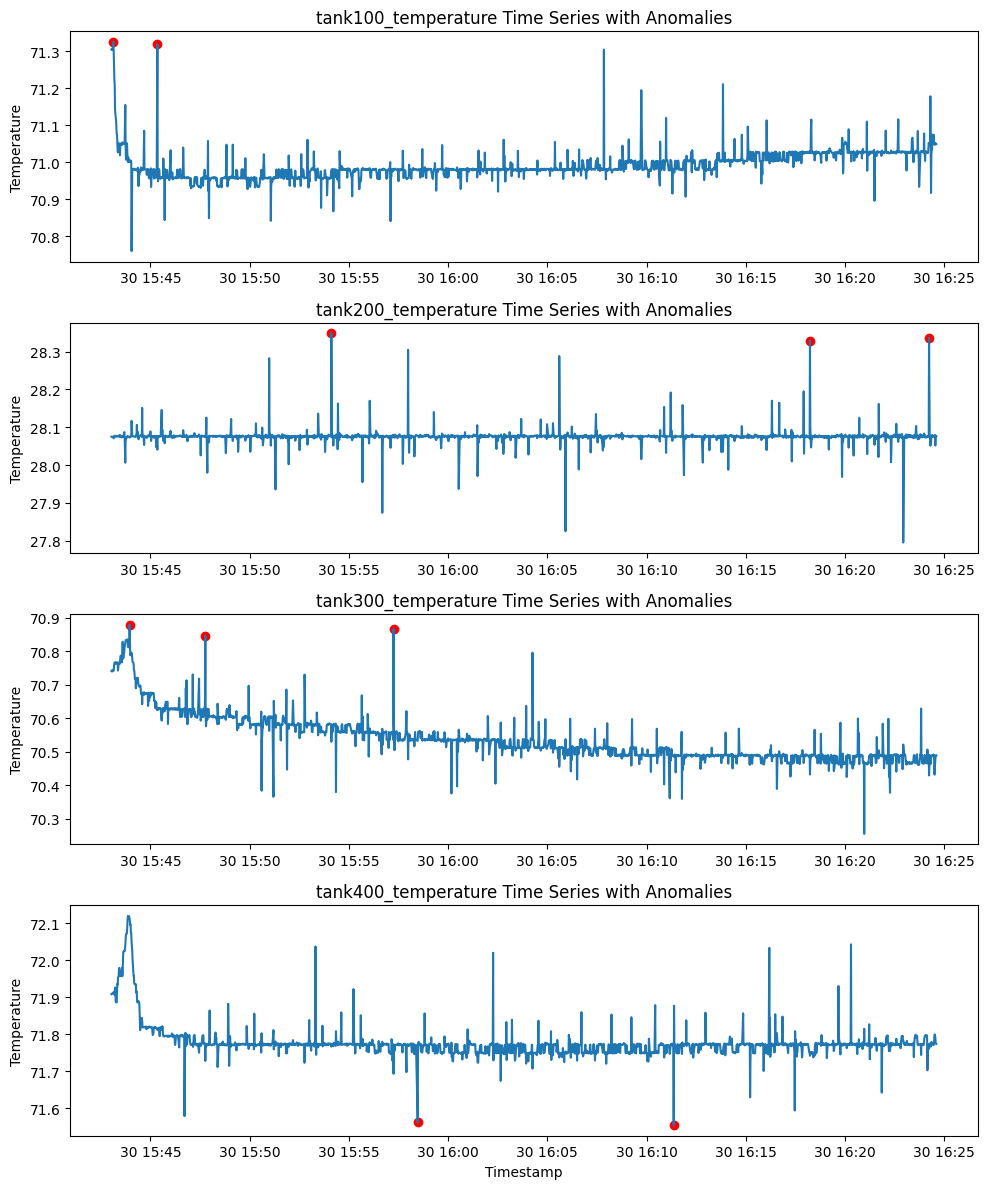

In [218]:
# Assuming output_df is your DataFrame and anomaly_columns is your list of columns
plot_combined_time_series_stack(df.copy(), temprature_list, 'Temperature')

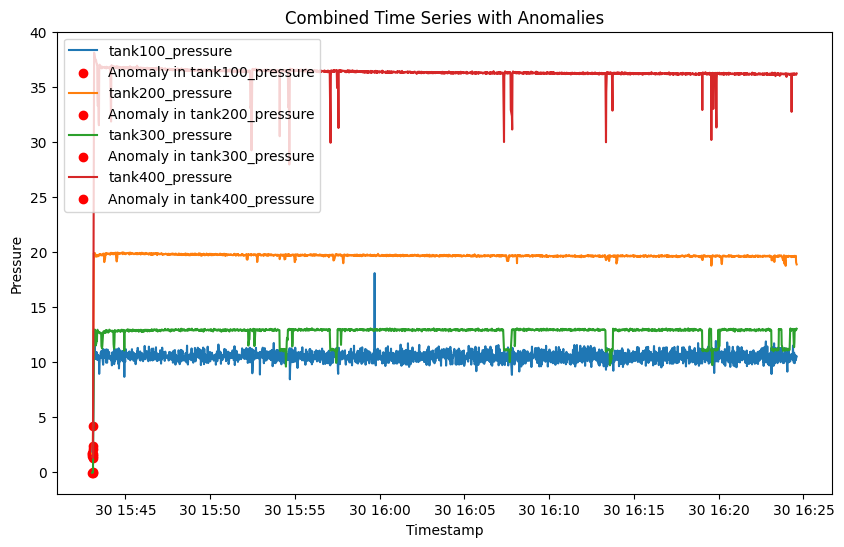

In [229]:
# Assuming output_df is your DataFrame and anomaly_columns is your list of columns
# plot_combined_time_series_overlap(df.copy(), pressure_list, 'Pressure')

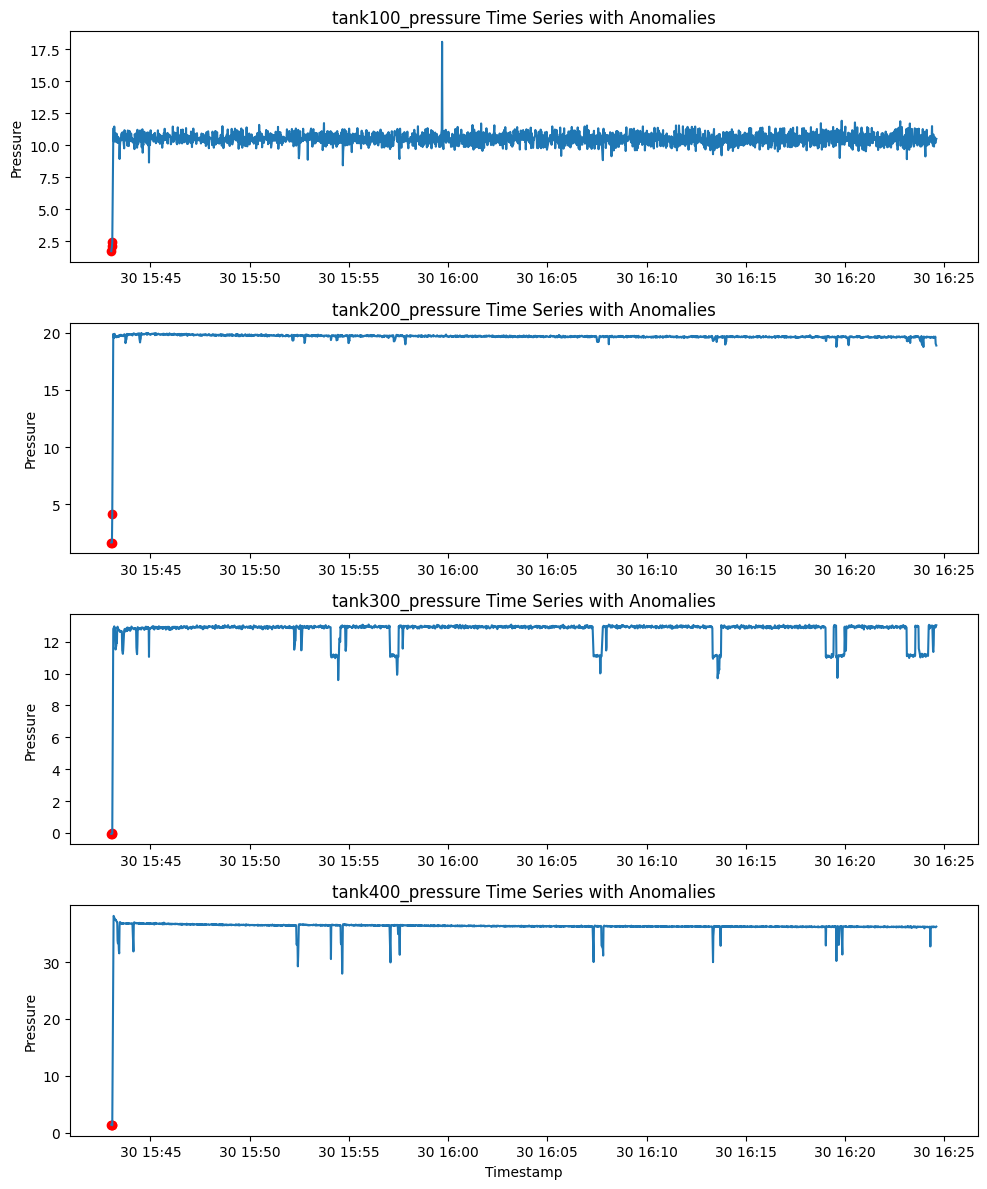

In [220]:
# Assuming output_df is your DataFrame and anomaly_columns is your list of columns
plot_combined_time_series_stack(df.copy(), pressure_list, 'Pressure')

In [231]:
# plot_combined_time_series_overlap(df.copy(), flow_rate_list, 'Flow rate')

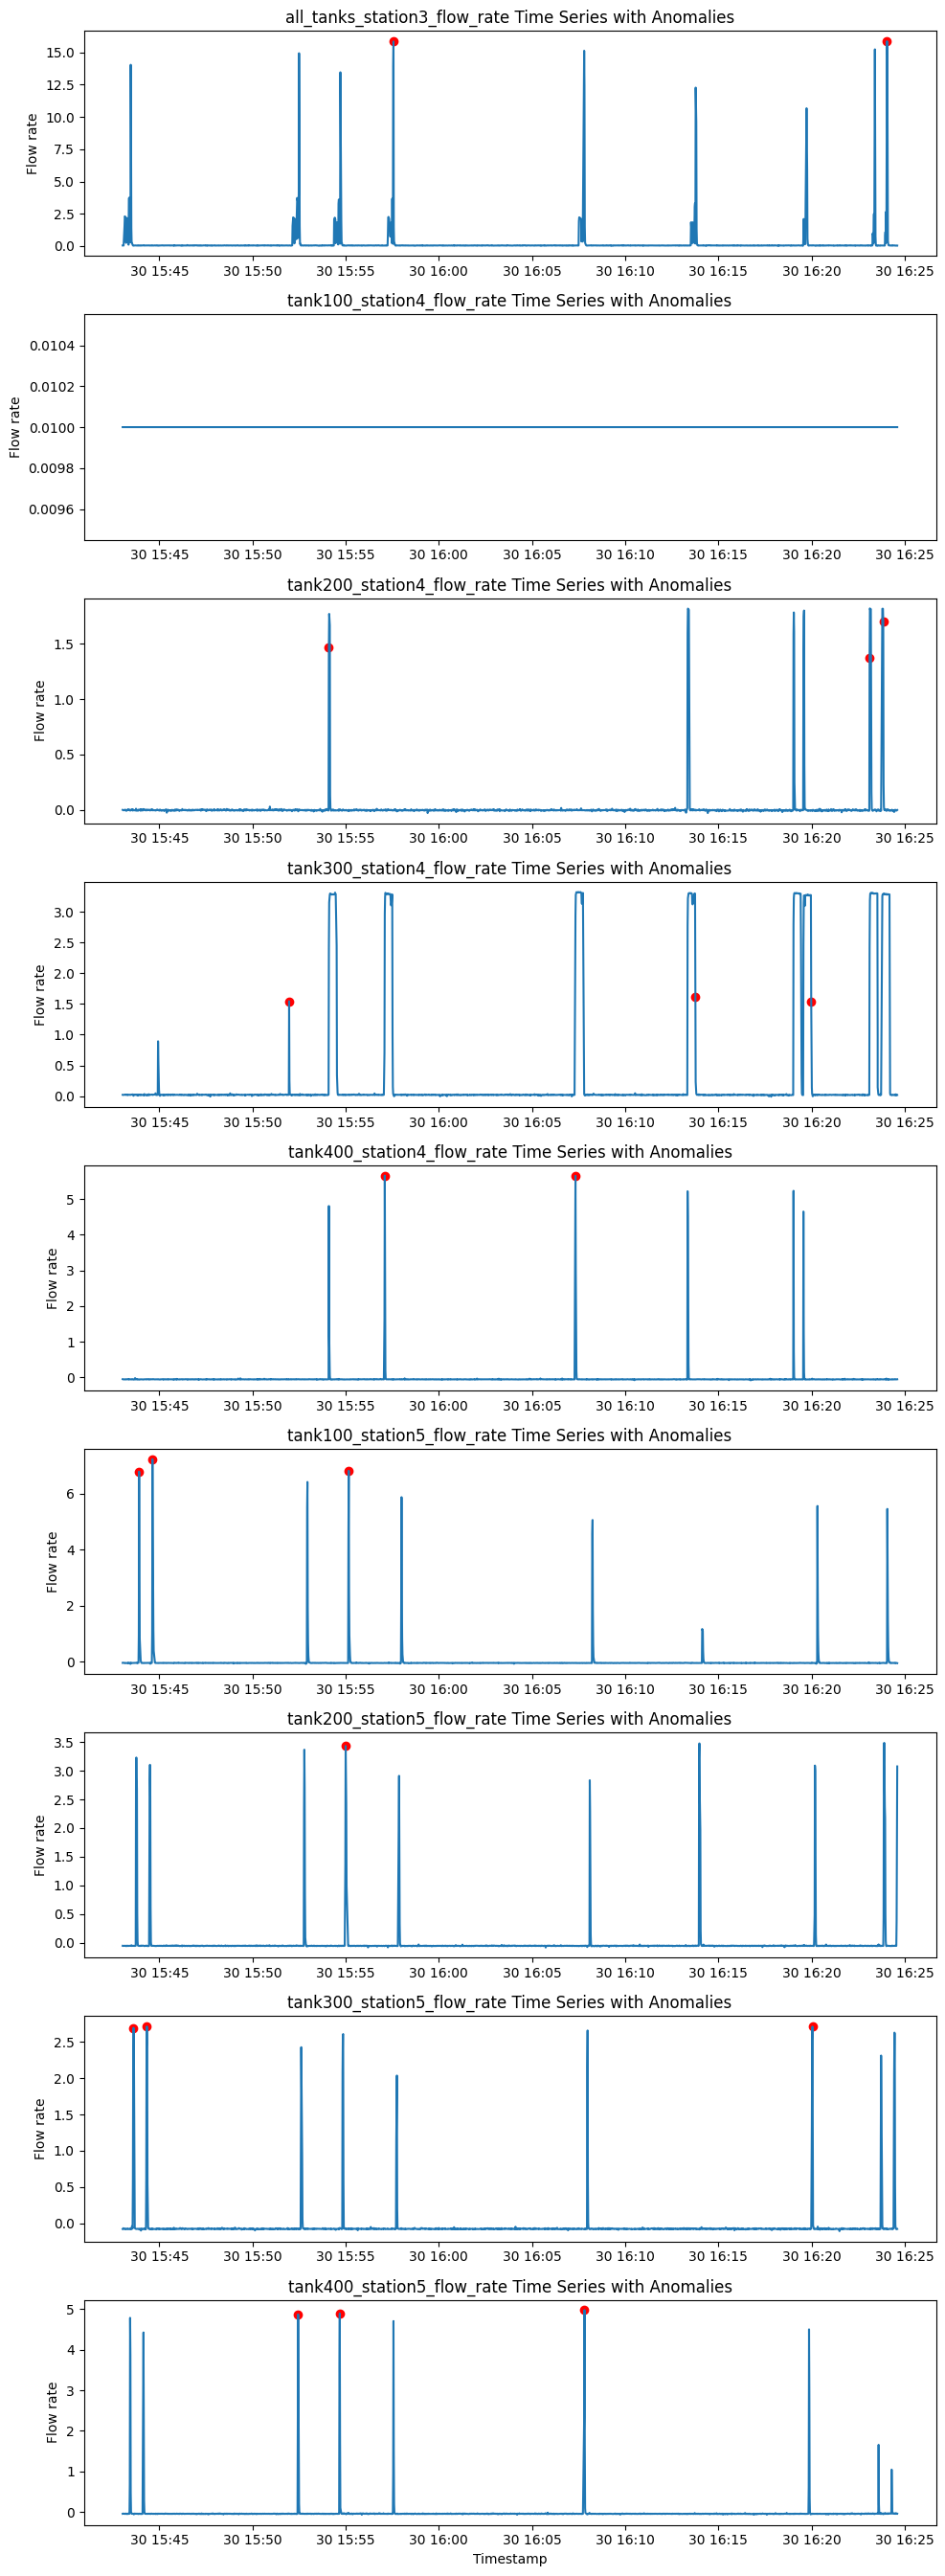

In [222]:
plot_combined_time_series_stack(df.copy(), flow_rate_list, 'Flow rate')

## Forecasted values

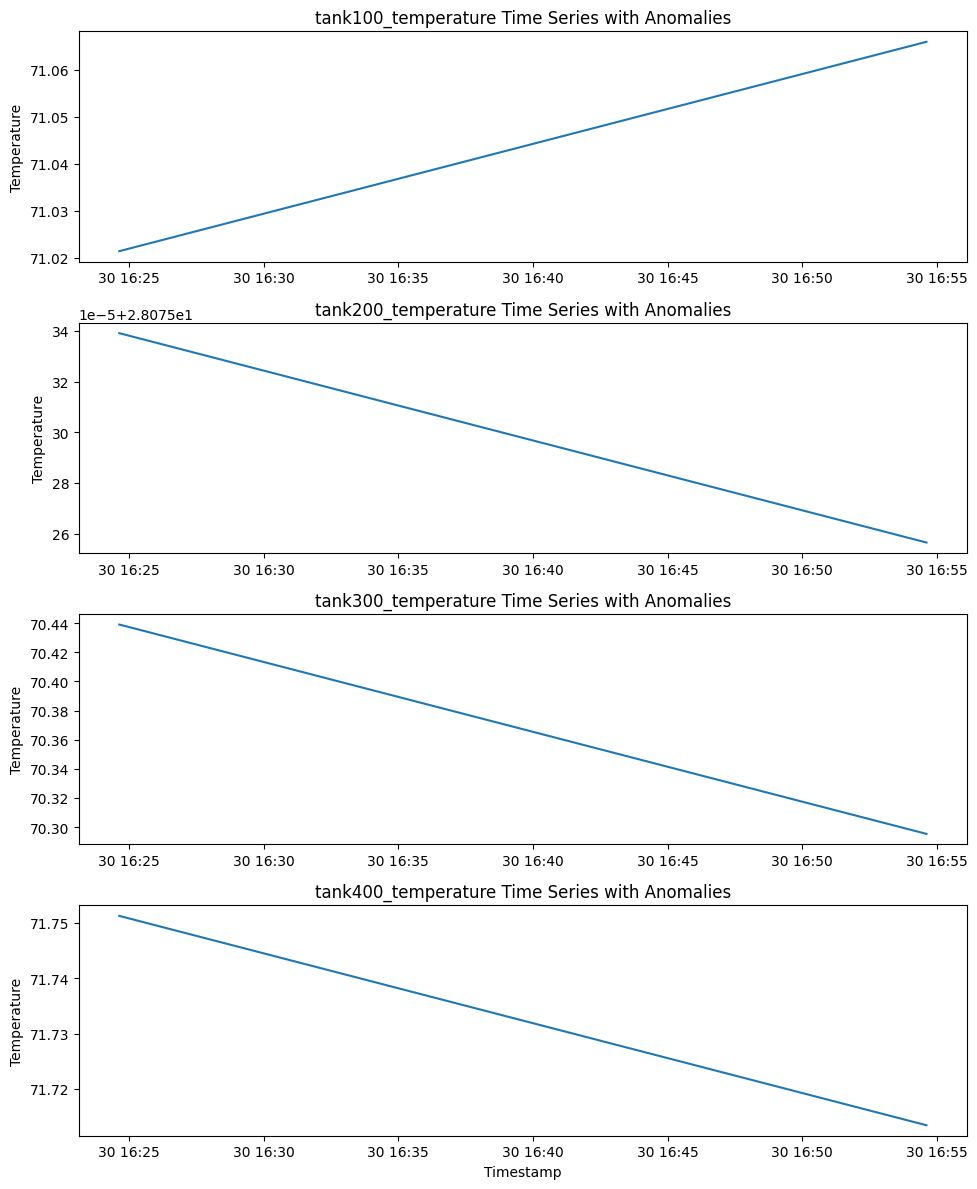

In [223]:
plot_combined_time_series_stack(output_df_with_prophet.copy(), temprature_list, 'Temperature')

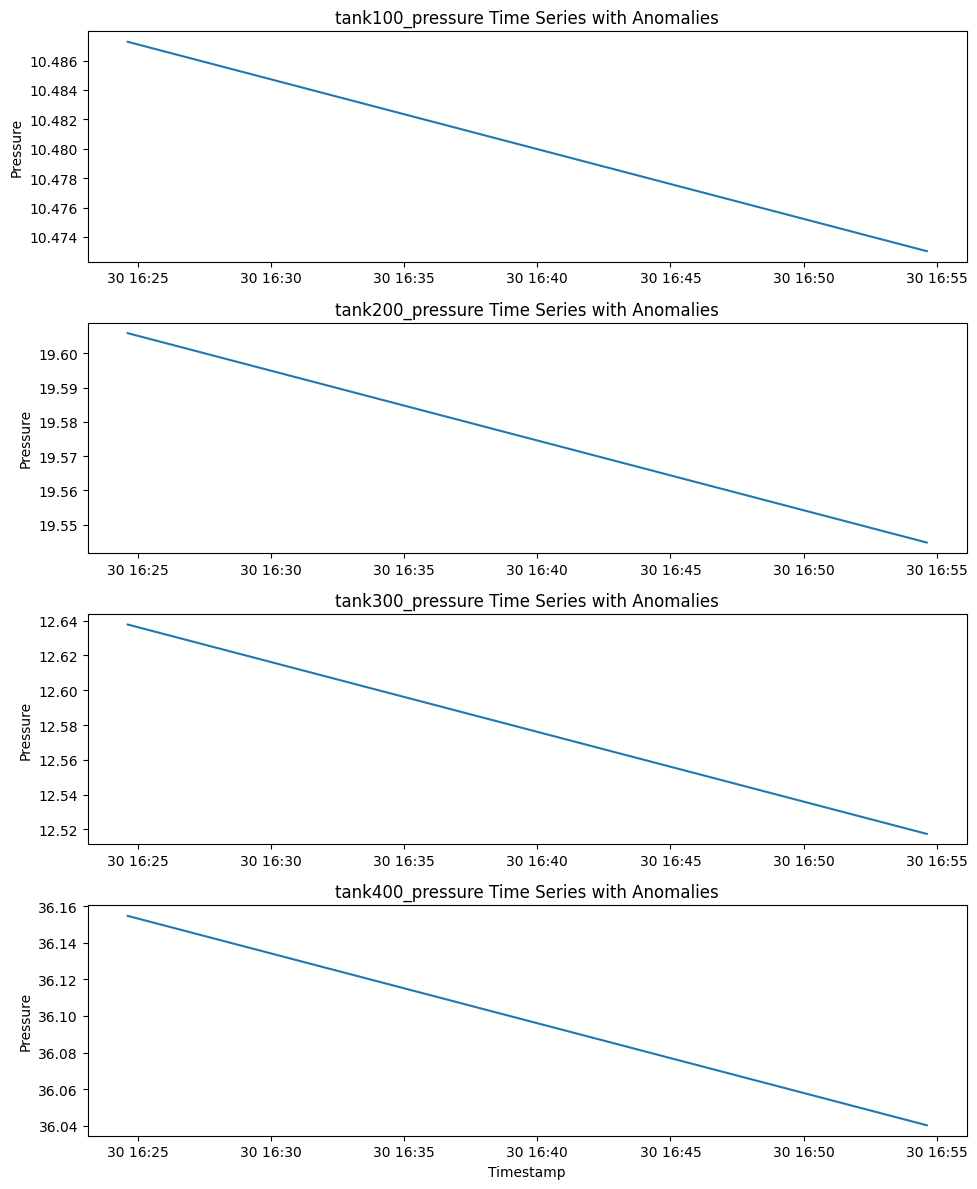

In [224]:
plot_combined_time_series_stack(output_df_with_prophet.copy(), pressure_list, 'Pressure')

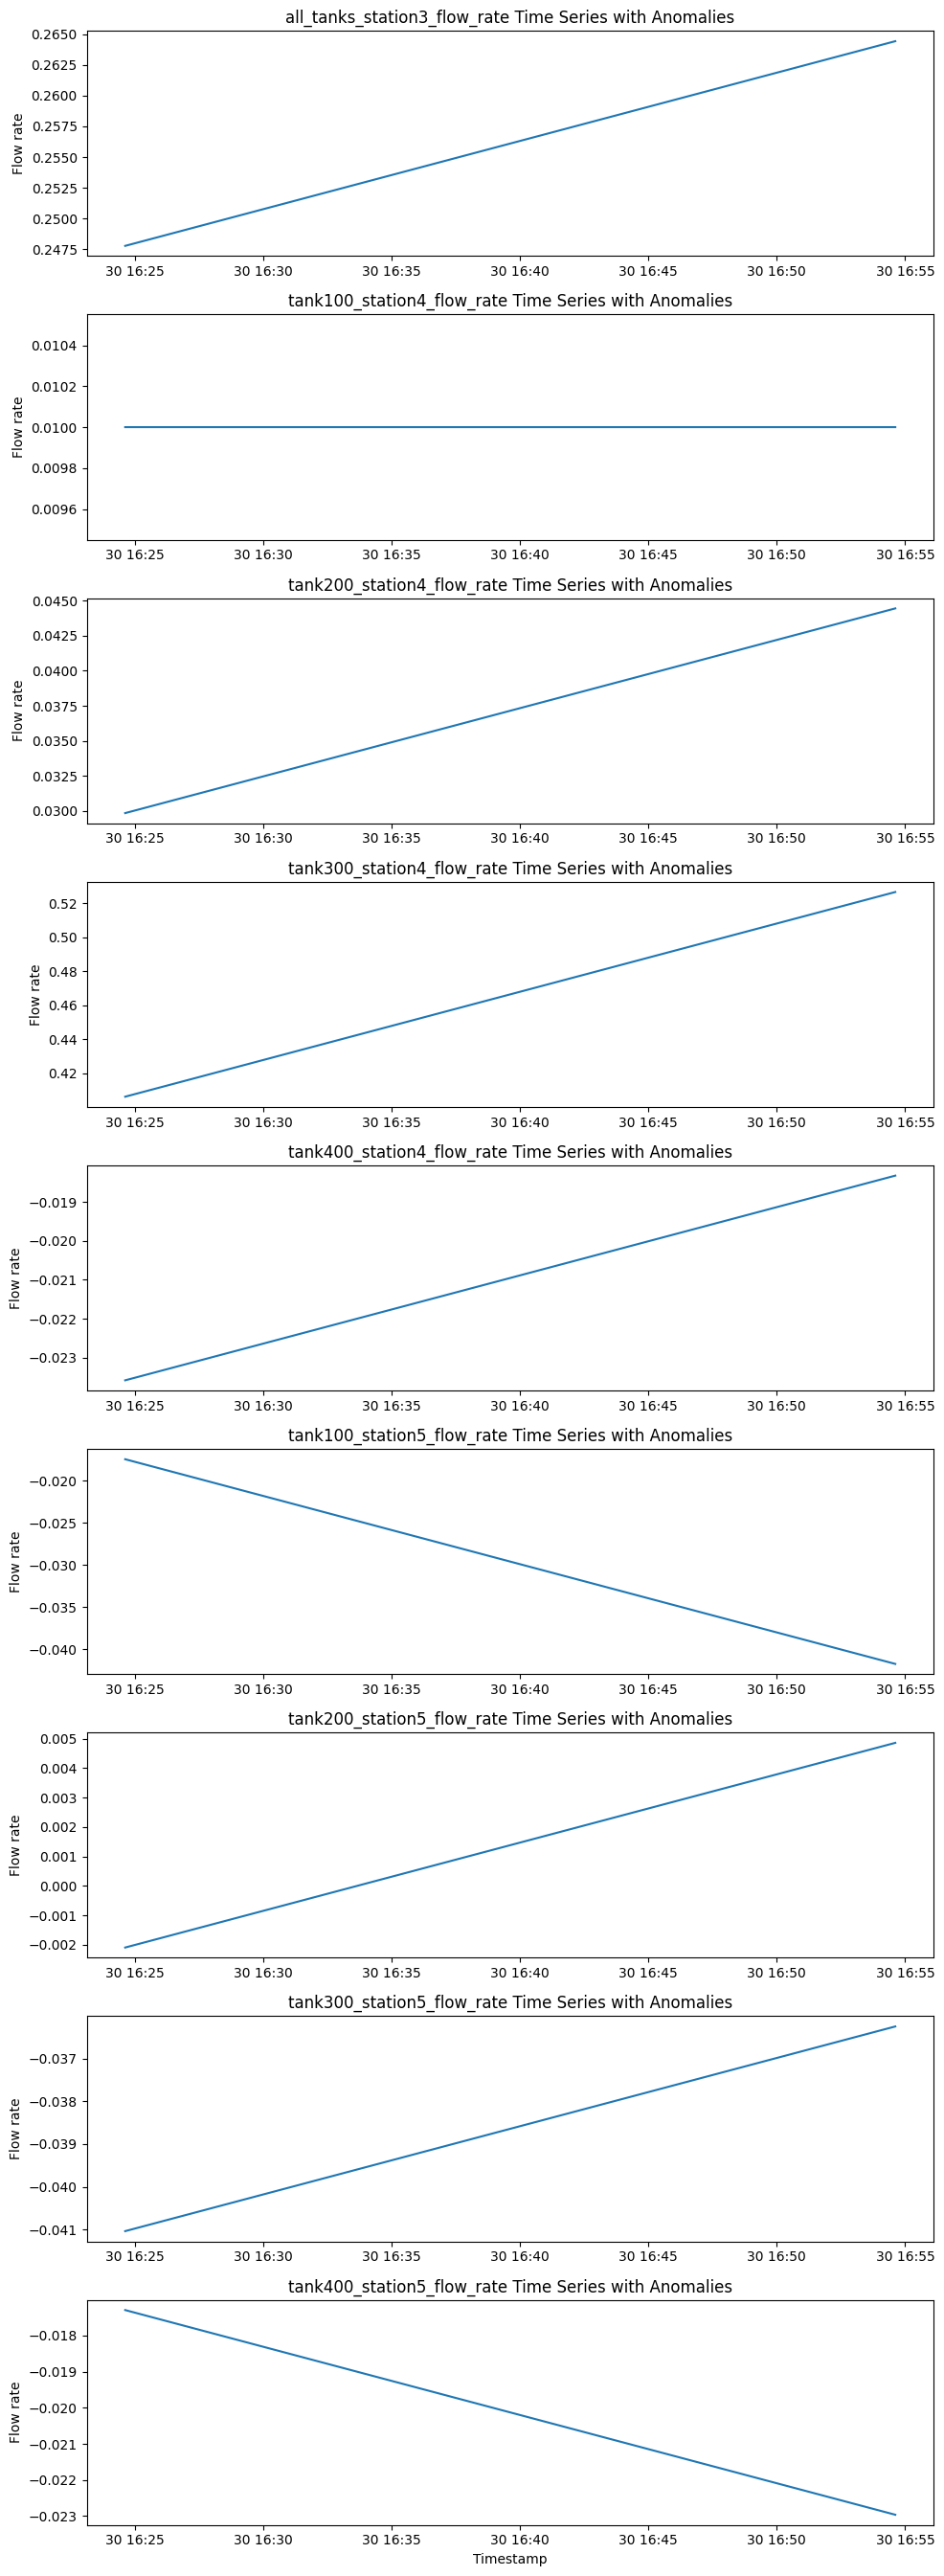

In [225]:
plot_combined_time_series_stack(output_df_with_prophet.copy(), flow_rate_list, 'Flow rate')

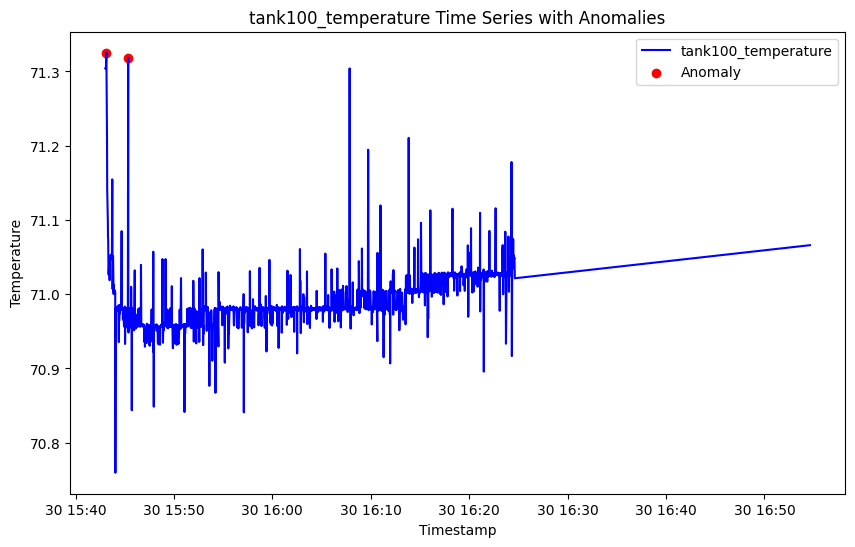

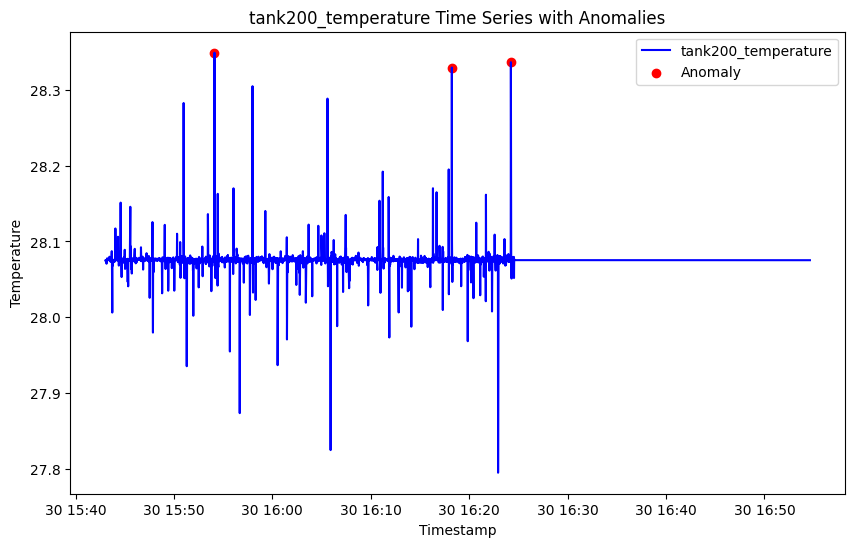

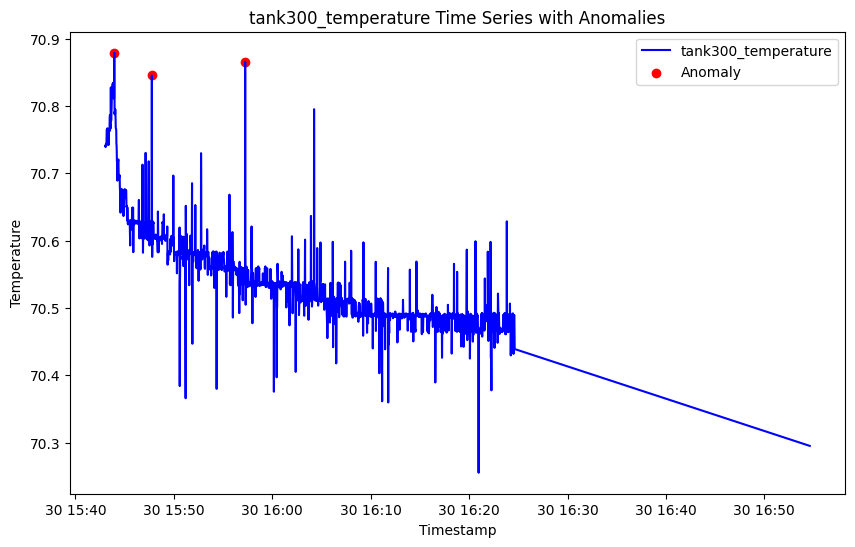

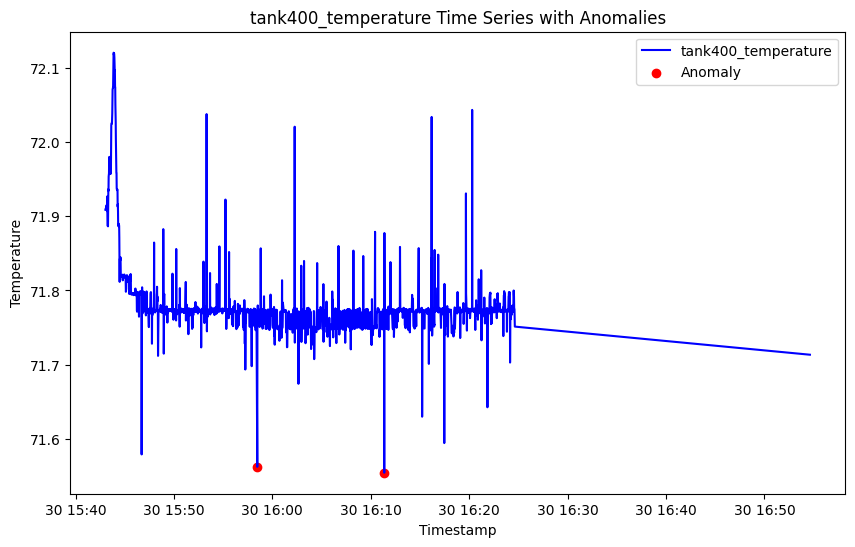

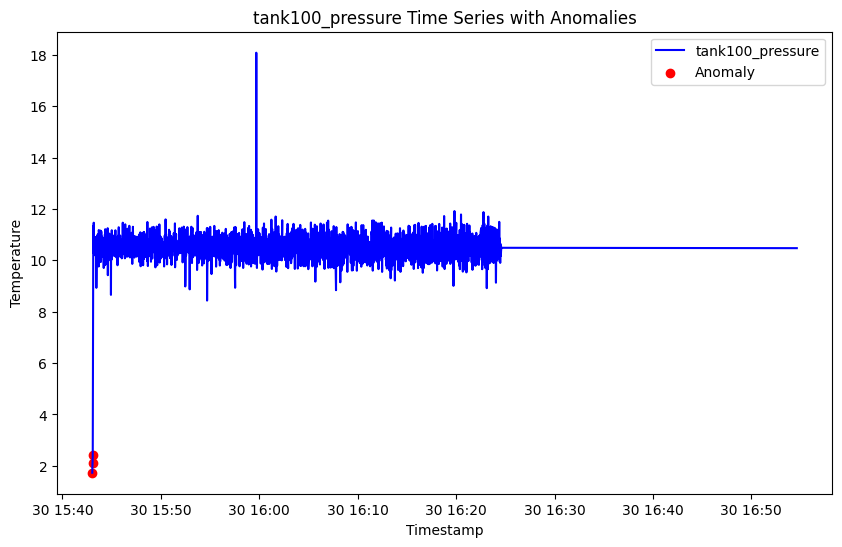

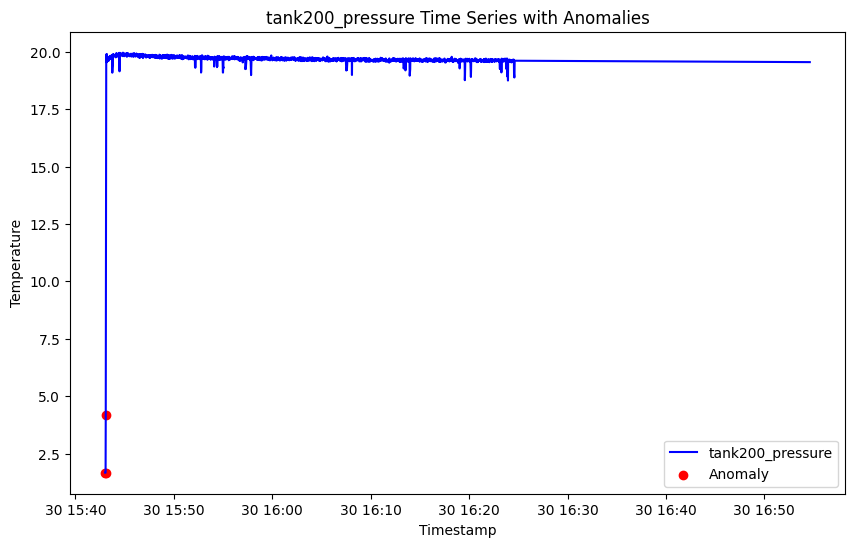

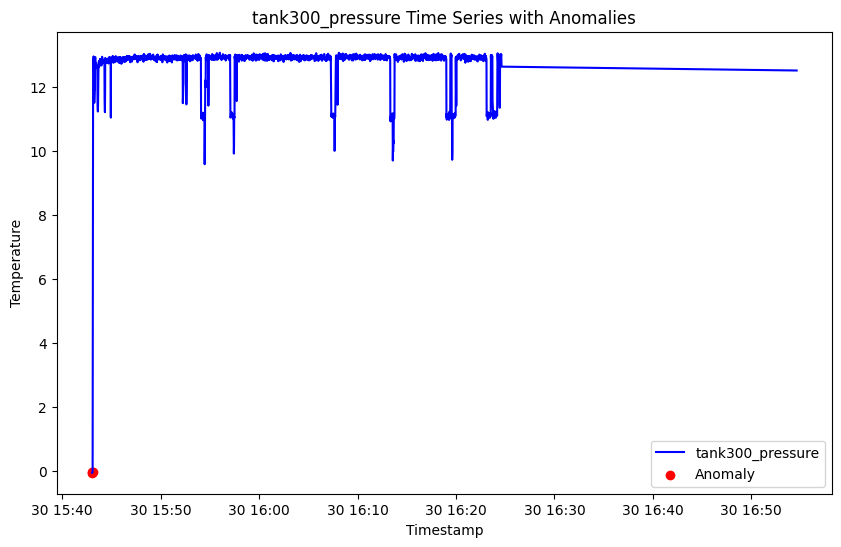

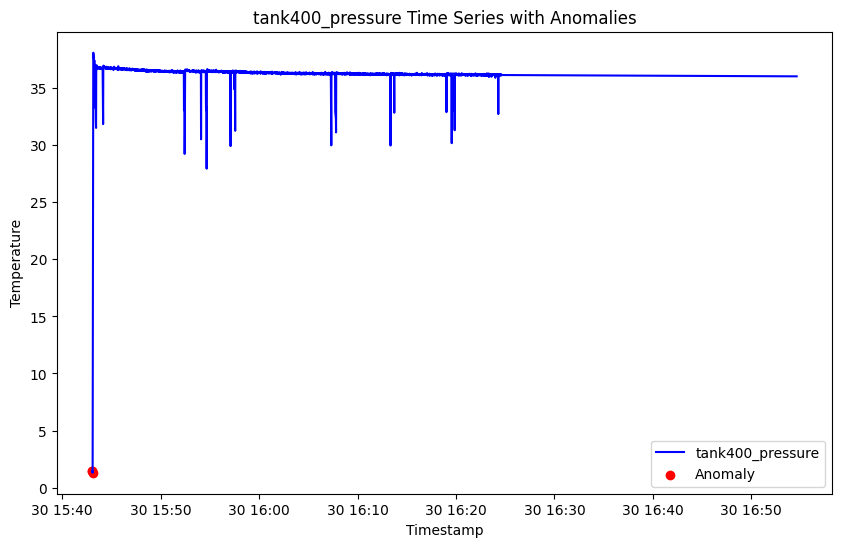

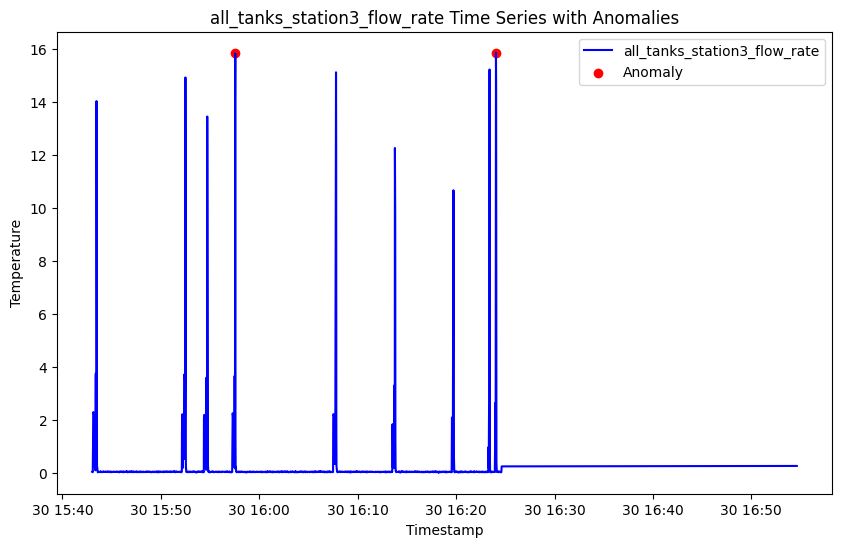

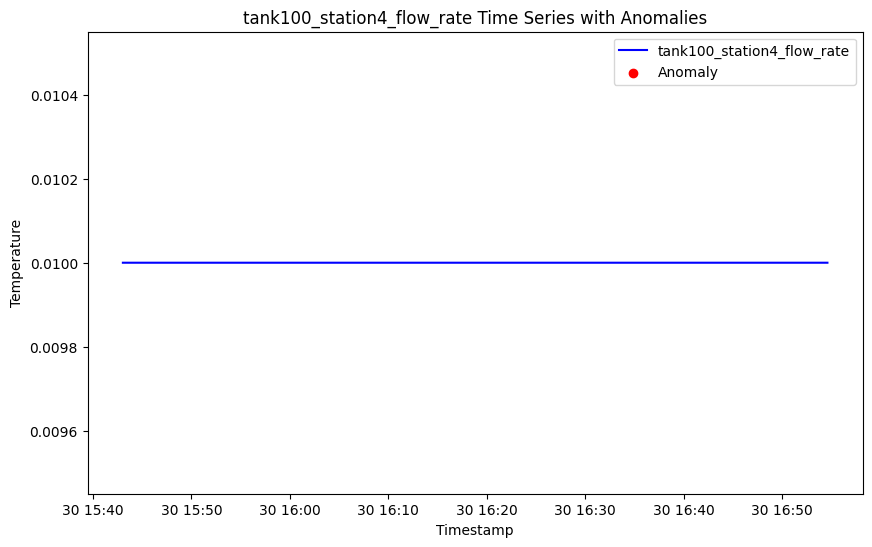

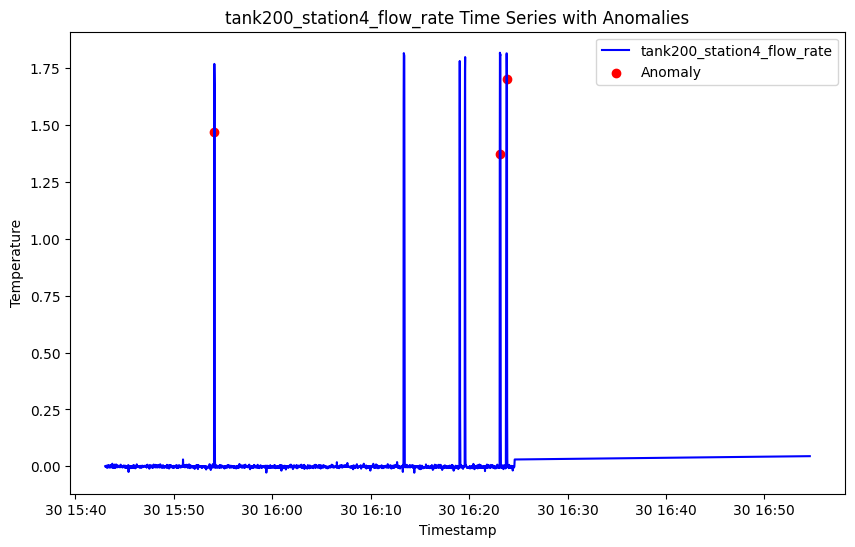

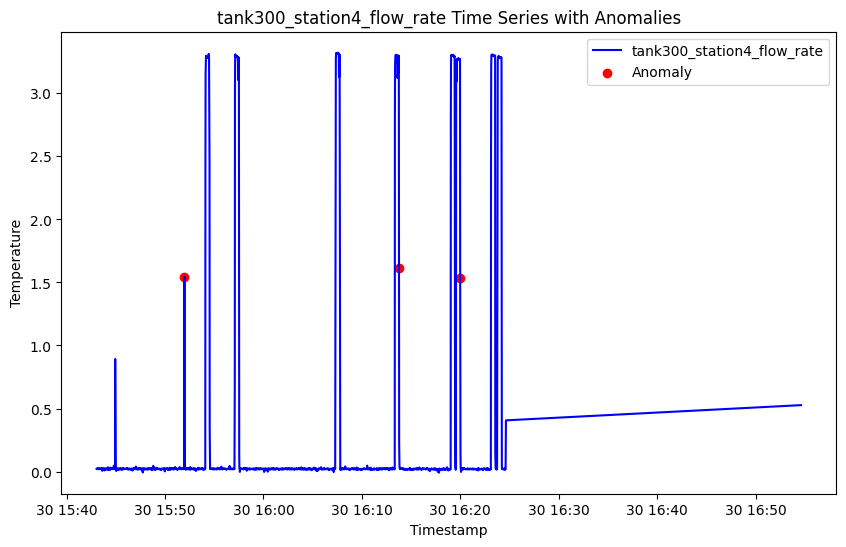

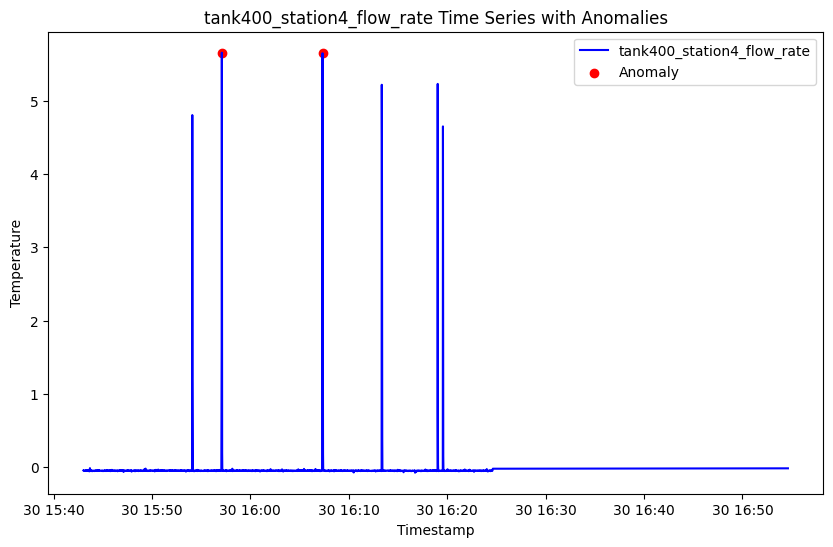

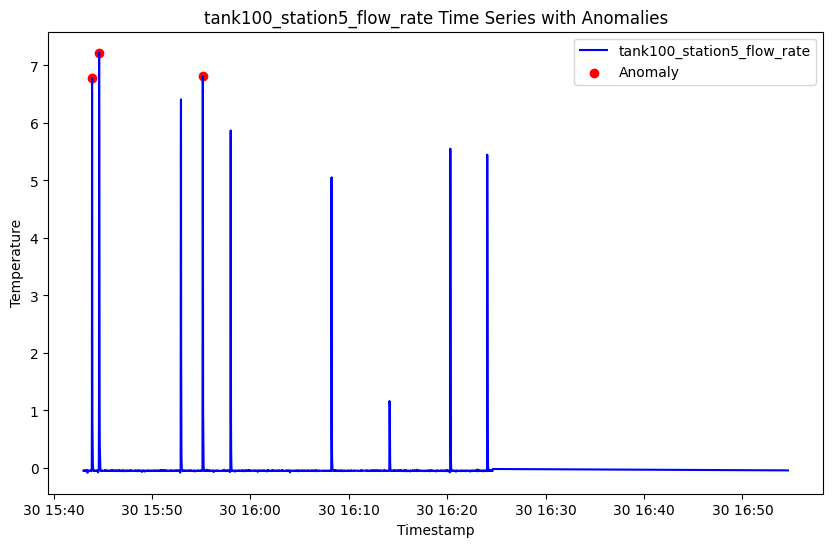

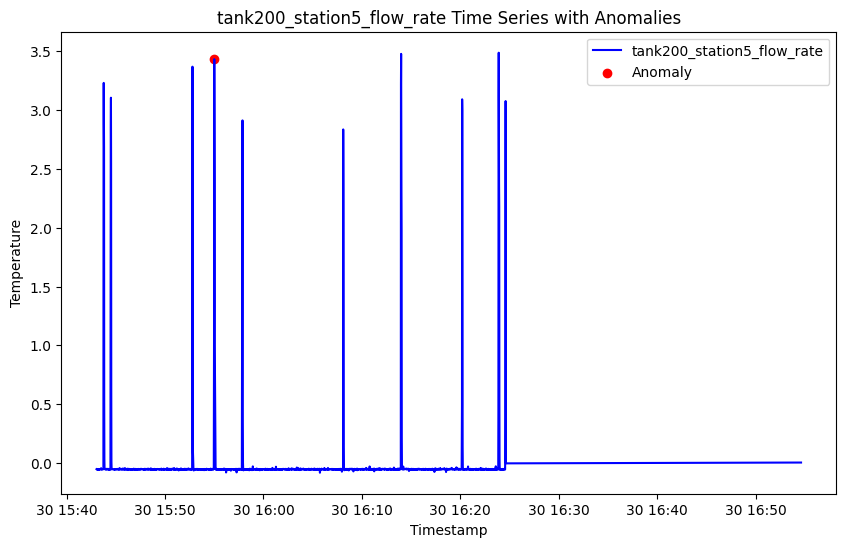

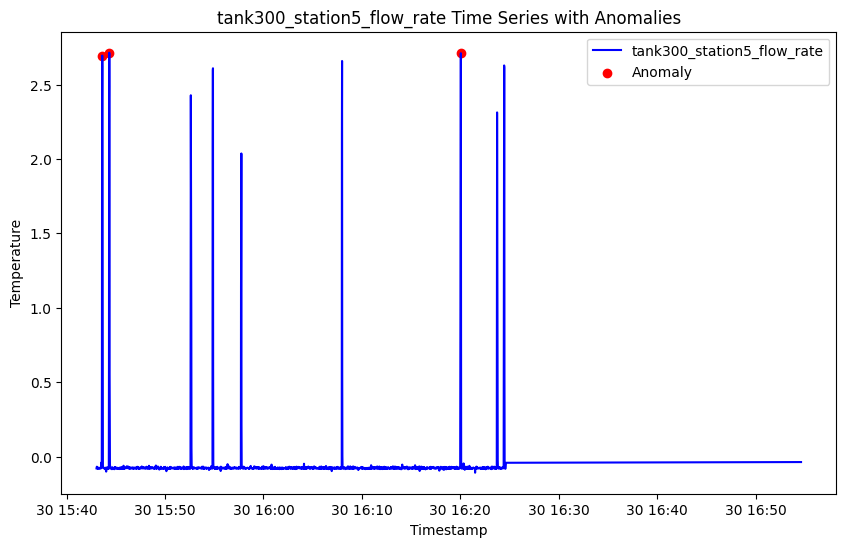

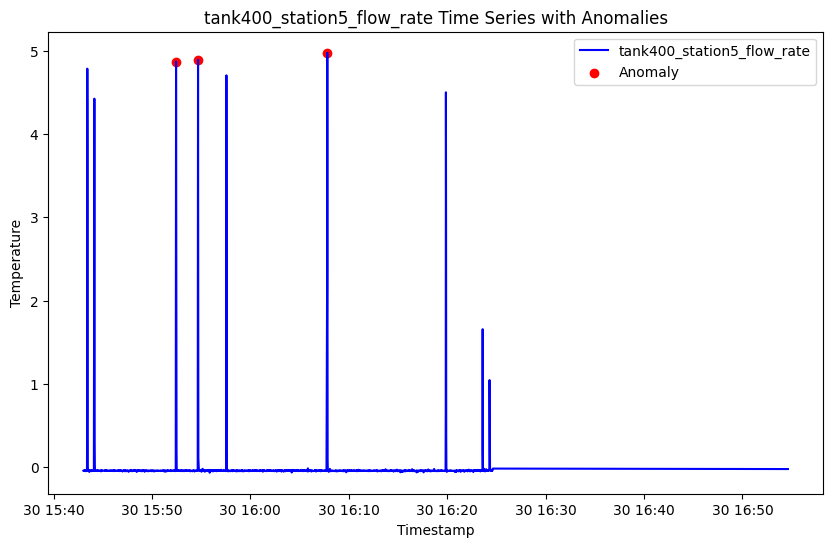

In [226]:
# Iterate over each pair of temperature and anomaly columns
for col in anomaly_columns:
    # Plot the time series data
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(output_df['Timestamp'], output_df[col], color='blue', label=col)

    # Highlight anomaly values in red
    anomaly_indices = output_df[output_df[col+'_is_anomaly'] == 1].index
    anomaly_values = output_df.loc[anomaly_indices, col]
    plt.scatter(output_df.loc[anomaly_indices, 'Timestamp'], anomaly_values, color='red', label='Anomaly')

    # Add labels and title
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature')
    plt.title(f'{col} Time Series with Anomalies')
    plt.legend()

    # Show plot
    plt.show()


In [227]:
# Iterate over each pair of temperature and anomaly columns
for col in anomaly_columns:
    # Plot the time series data
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(output_df['Timestamp'], output_df[col], color='blue', label=col)

    # Highlight anomaly values in red
    anomaly_indices = output_df[output_df[col+'_is_anomaly'] == -1].index
    anomaly_values = output_df.loc[anomaly_indices, col]
    plt.scatter(output_df.loc[anomaly_indices, 'Timestamp'], anomaly_values, color='red', label='Anomaly')

    # Add labels and title
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.title(f'{col} Time Series with Anomalies')
    plt.legend()

    # Save plot as PNG file
    plt.savefig(f'reports/{col}_time_series_with_anomalies.png')

    # Close the plot to free up memory
    plt.close()